In [14]:
import sys
sys.path.append("../../")
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import seaborn as sns
from simulations.dim_complexity.train_models import SimModel, low_dims
import simulations.figure_style

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def model_predictions(gt: bool, func: int, dim: int) -> tuple[np.ndarray, np.ndarray]:
    if gt:
        state_dict = torch.load("saved_models/gt.pth")
    elif dim == 0:
        state_dict = torch.load(f"saved_models/func={func}.pth")
    else:
        state_dict = torch.load(f"saved_models/dim={dim},func={func}.pth")
    model = SimModel().eval().to(device)
    model.load_state_dict(state_dict)
    
    x = np.linspace(-1, 1, 100)
    x_tensor = torch.from_numpy(x).float().to(device)
    with torch.no_grad():
        y = model(x_tensor.unsqueeze(1)).squeeze(1)
    y = y.detach().cpu().numpy()

    return x, y


def plot_model(gt, func, dim, ax: plt.Axes, **kwargs) -> None:
    x, y = model_predictions(gt, func, dim)
    sns.lineplot(x=x, y=y, ax=ax, **kwargs)

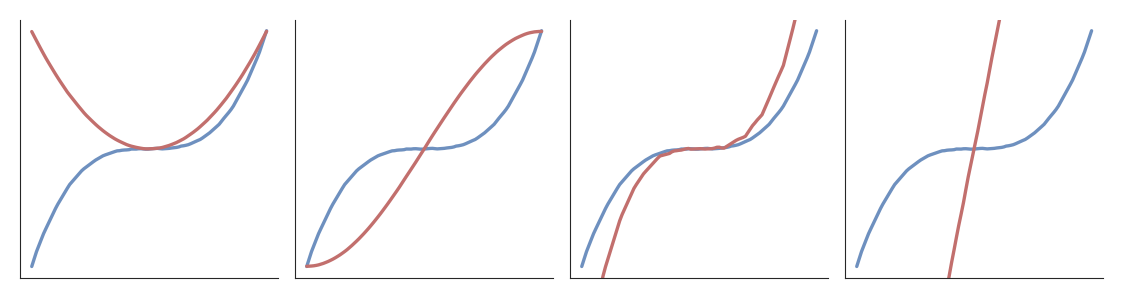

In [36]:
from turtle import color


fig, axs = plt.subplots(1, 4, figsize=(5.5, 5.5 / 4))

palette = sns.color_palette("vlag")
palette_cont = sns.color_palette("vlag", as_cmap=True)

for i, ax in enumerate(axs):
    plot_model(True, 0, 0, ax=ax, color=palette[0])
    plot_model(False, i, 0, ax=ax, color=palette[-1])

    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
    ax.tick_params(axis="both", which="both", 
                   bottom=False, left=False, 
                   labelbottom=False, labelleft=False)
    
plt.show()